# EfficientNetB2: Transfer Learning and Fine Tuning

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Copia Challenge 1

Mounted at /gdrive
/gdrive/My Drive/Copia Challenge 1


### Imports

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications.efficientnet import preprocess_input

2.14.0


### Loading the data

In [4]:
# loading the data
loaded = np.load('clean_public_data.npz', allow_pickle=True)
data = loaded['data']
labels = loaded['labels']

In [5]:
# Normalize data to the range [0, 1]
data = (data / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
labels = pd.get_dummies(labels)

### Splitting the data

In [6]:
# Split data into training and validation sets, maintaining class distribution
data_train_val, data_test, labels_train_val, labels_test = train_test_split(data, labels, random_state=seed, test_size=0.1, stratify=labels)

# Split data into training and test sets, maintaining class distribution
data_train, data_val, labels_train, labels_val = train_test_split(data_train_val, labels_train_val, random_state=seed, test_size=0.1, stratify=labels_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", data_train.shape)
print("Training Label Shape:", labels_train.shape)
print("Validation Data Shape:", data_val.shape)
print("Validation Label Shape:", labels_val.shape)
print("Test Data Shape:", data_val.shape)
print("Test Label Shape:", labels_val.shape)

Training Data Shape: (4052, 96, 96, 3)
Training Label Shape: (4052, 2)
Validation Data Shape: (451, 96, 96, 3)
Validation Label Shape: (451, 2)
Test Data Shape: (451, 96, 96, 3)
Test Label Shape: (451, 2)


In [7]:
# Define key model parameters
input_shape = data_train.shape[1:]    # Input shape for the model
output_shape = labels_train.shape[1]  # Output shape for the model
batch_size = 64                       # Batch size for training
epochs = 1000                         # Number of training epochs

## Transfer Learning

In [8]:
def build_EfficientNet(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Define a preprocessing Sequential model with random flip and random rotation
    preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip(mode='horizontal'),
        tfkl.RandomFlip(mode='vertical'),
        tfkl.RandomRotation(0.2),
    ], name='preprocessing')

    # Build the neural network layer by layer
    supernet = tfk.applications.EfficientNetB2(
      include_top=False,
      weights="imagenet",
      input_shape=(96,96,3),
      pooling='avg',
      classifier_activation='softmax'
      )

    supernet.summary()
    tfk.utils.plot_model(supernet)


    supernet.trainable = False

    inputs = tfk.Input(shape=(96,96,3))
    x = preprocessing(inputs)
    x = supernet(x)
    x = tfkl.Flatten(name='Flattening')(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)

    # Adding a Dense layer and Dropout
    x = tfkl.Dense(256, activation='relu', kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
    x = tfkl.Dropout(0.3, seed=seed)(x)

    output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=output_layer, name='EfficientNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [9]:
model = build_EfficientNet(input_shape, output_shape)
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, mode='max', restore_best_weights=True)

31790344/31790344 [==============================] - 0s 0us/step
Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 96, 96, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

### Training the model

In [10]:
# Train the model and save its history
history = model.fit(
    x=preprocess_input(data_train*255),
    y=labels_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(preprocess_input(data_val*255), labels_val),
    callbacks=[early_stopping]
).history

Epoch 1/1000
64/64 [==============================] - 27s 125ms/step - loss: 0.5710 - accuracy: 0.6915 - val_loss: 0.5039 - val_accuracy: 0.7361
Epoch 2/1000
64/64 [==============================] - 4s 57ms/step - loss: 0.5072 - accuracy: 0.7446 - val_loss: 0.4621 - val_accuracy: 0.7761
Epoch 3/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.5023 - accuracy: 0.7614 - val_loss: 0.4593 - val_accuracy: 0.7694
Epoch 4/1000
64/64 [==============================] - 3s 47ms/step - loss: 0.4730 - accuracy: 0.7786 - val_loss: 0.4560 - val_accuracy: 0.7627
Epoch 5/1000
64/64 [==============================] - 3s 49ms/step - loss: 0.4652 - accuracy: 0.7757 - val_loss: 0.4158 - val_accuracy: 0.8004
Epoch 6/1000
64/64 [==============================] - 3s 52ms/step - loss: 0.4638 - accuracy: 0.7799 - val_loss: 0.4258 - val_accuracy: 0.8004
Epoch 7/1000
64/64 [==============================] - 4s 58ms/step - loss: 0.4605 - accuracy: 0.7796 - val_loss: 0.4416 - val_accuracy: 0.78

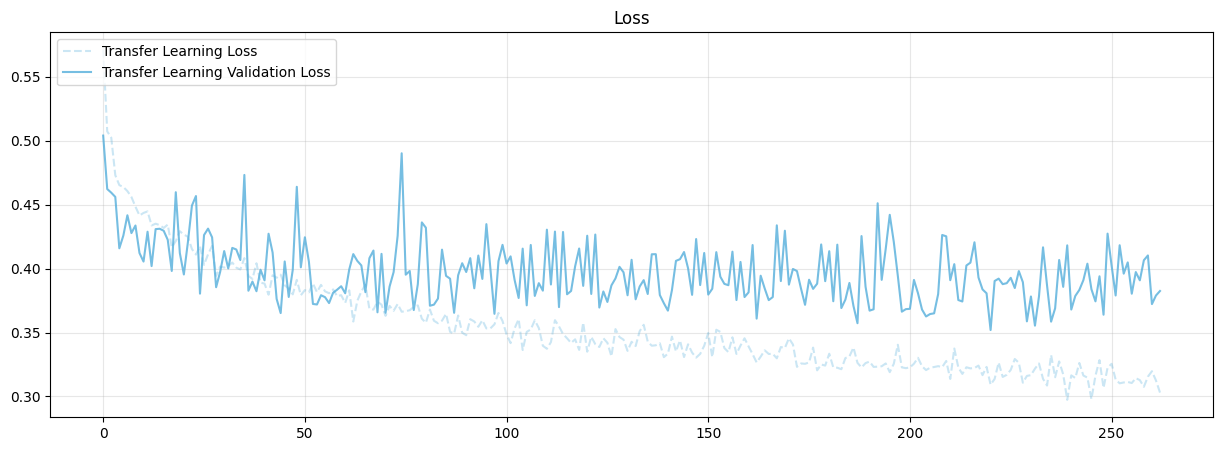

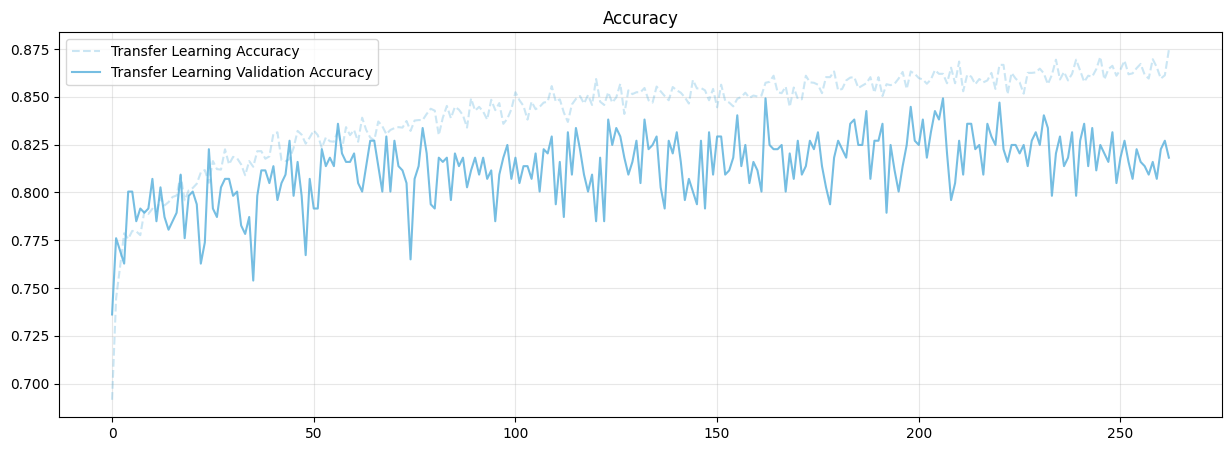

In [11]:
# Plot the transfer learning loss and val loss
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label="Transfer Learning Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning Validation Loss', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

# Plot the transfer learning accuracy and val accuracy
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Transfer Learning Accuracy', alpha=.3, color='#54aedb', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning Validation Accuracy', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [12]:
# Predict labels for the entire test set
predictions = model.predict(data_test*255, verbose=0)

In [13]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(preprocess_input(data_test*255),labels_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8703


In [14]:
y = np.array(labels_test)

## Confusion matrix

Accuracy: 0.8703
Precision: 0.8726
Recall: 0.8499
F1: 0.8586


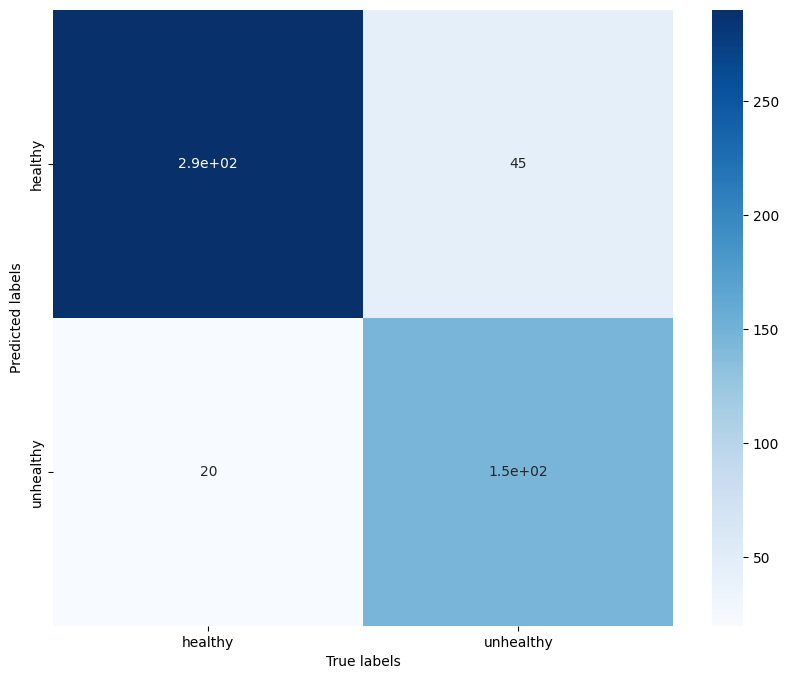

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(("healthy", "unhealthy")), yticklabels=list(("healthy", "unhealthy")), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [16]:
# Save the trained model
model.save('EfficientNet')
del model

## Fine Tuning

In [17]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('EfficientNet')
ft_model.summary()

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetb2 (Functional  (None, 1408)              7768569   
 )                                                               
                                                                 
 Flattening (Flatten)        (None, 1408)              0         
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                      

In [18]:
# Set all EfficientNet layers as trainable
ft_model.get_layer('efficientnetb2').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 block2

In [19]:
# Freeze first 268 layers
N = 268
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_reduce F

In [20]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [21]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(data_train*255), # We need to apply the preprocessing thought for the EfficientNetB2 network
    y = labels_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (preprocess_input(data_val*255), labels_val), # We need to apply the preprocessing thought for the EfficientNetB2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
64/64 [==============================] - 28s 128ms/step - loss: 1.5625 - accuracy: 0.6024 - val_loss: 0.4382 - val_accuracy: 0.7982
Epoch 2/200
64/64 [==============================] - 4s 63ms/step - loss: 1.3079 - accuracy: 0.6449 - val_loss: 0.5578 - val_accuracy: 0.7783
Epoch 3/200
64/64 [==============================] - 4s 62ms/step - loss: 1.1711 - accuracy: 0.6710 - val_loss: 0.6257 - val_accuracy: 0.7627
Epoch 4/200
64/64 [==============================] - 5s 74ms/step - loss: 1.1135 - accuracy: 0.6871 - val_loss: 0.6669 - val_accuracy: 0.7583
Epoch 5/200
64/64 [==============================] - 4s 70ms/step - loss: 1.0123 - accuracy: 0.7043 - val_loss: 0.6881 - val_accuracy: 0.7517
Epoch 6/200
64/64 [==============================] - 4s 63ms/step - loss: 1.0094 - accuracy: 0.7100 - val_loss: 0.6808 - val_accuracy: 0.7583
Epoch 7/200
64/64 [==============================] - 5s 75ms/step - loss: 0.9810 - accuracy: 0.7201 - val_loss: 0.6838 - val_accuracy: 0.7605
Epoc

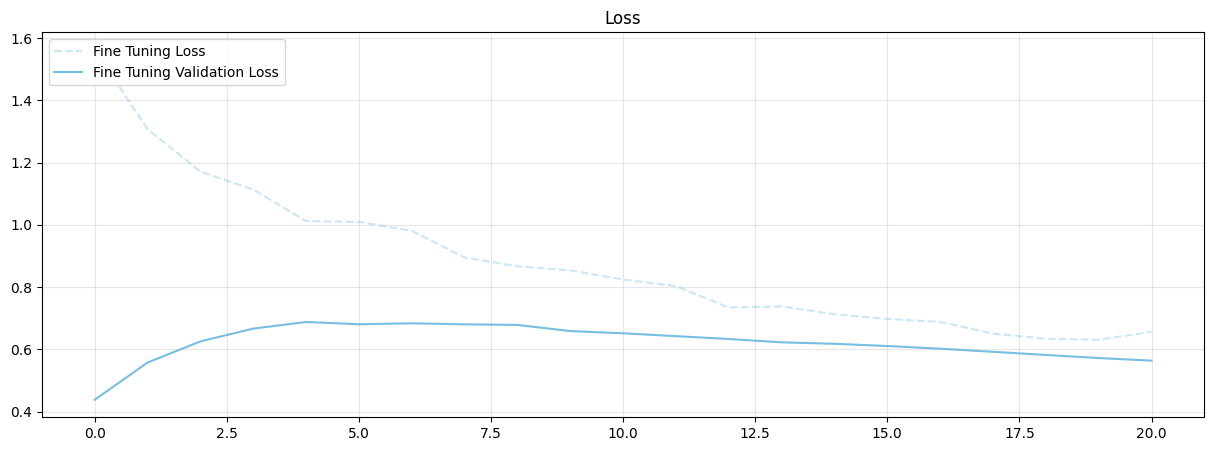

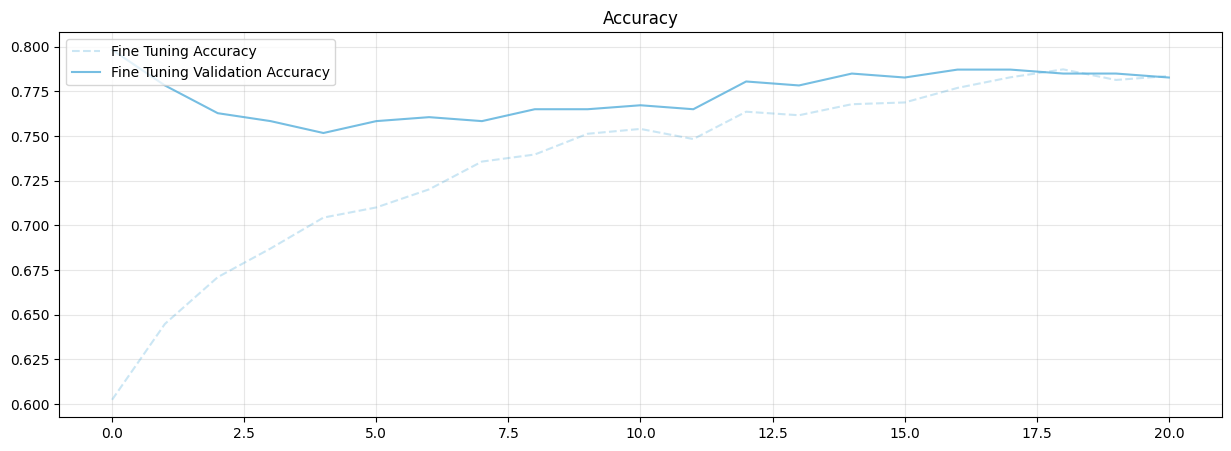

In [22]:
# Plot the fine tuning loss and val loss
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], label="Fine Tuning Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning Validation Loss', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

# Plot the fine tuning accuracy and val accuracy
plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], label='Fine Tuning Accuracy', alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning Validation Accuracy', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

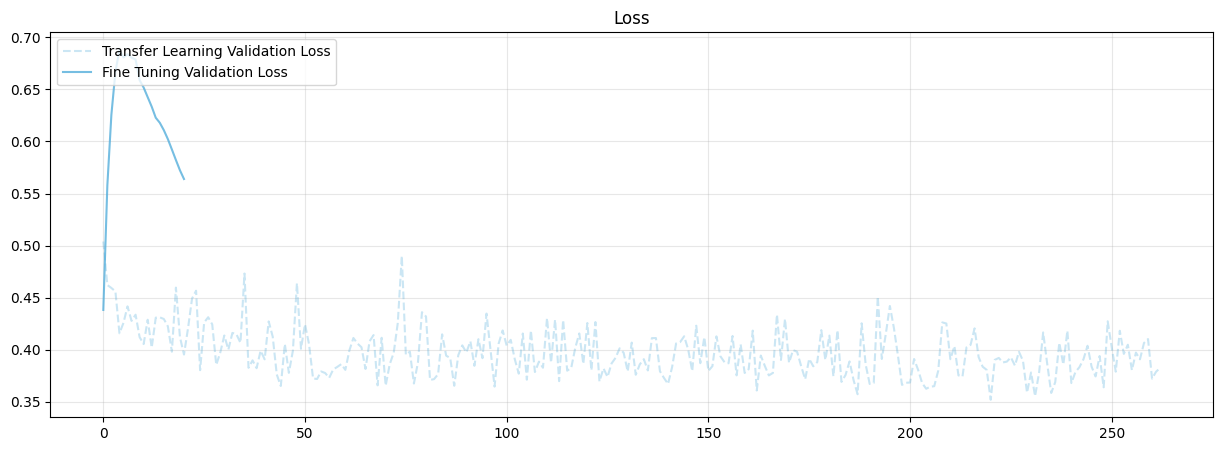

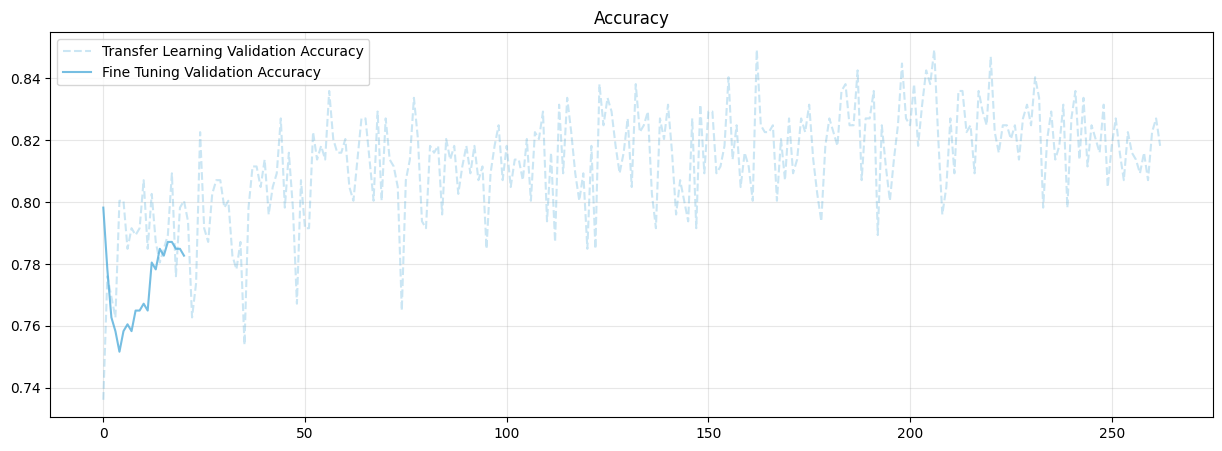

In [23]:
# Plot the transfer learning validation loss and fine tuning validation loss
plt.figure(figsize=(15,5))
plt.plot(history['val_loss'], label="Transfer Learning Validation Loss", alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning Validation Loss', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)

# Plot the transfer learning validation accuracy and fine tuning validation accuracy
plt.figure(figsize=(15,5))
plt.plot(history['val_accuracy'], label='Transfer Learning Validation Accuracy', alpha=.3, color='#54aedb', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning Validation Accuracy', alpha=.8, color='#54aedb')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [24]:
# Predict labels for the entire test set
predictions = ft_model.predict(data_test*255, verbose=0)

In [25]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(data_test*255),labels_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8224


In [26]:
y = np.array(labels_test)

### Confusion Matrix

Accuracy: 0.8224
Precision: 0.8155
Recall: 0.8032
F1: 0.8082


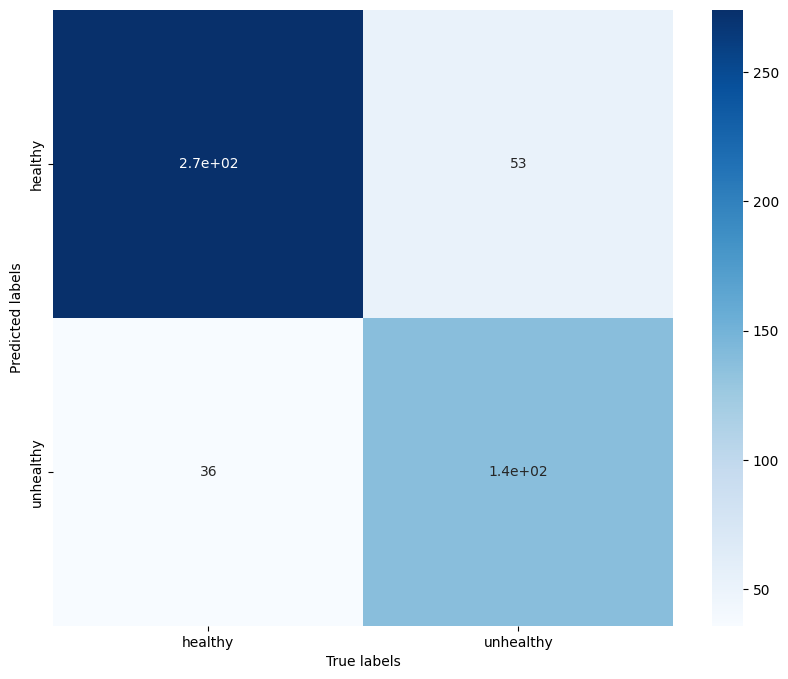

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(("healthy", "unhealthy")), yticklabels=list(("healthy", "unhealthy")), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [28]:
# Save the best model
ft_model.save('EfficientNetTuning')
del ft_model